In [258]:
import itertools as itt
from collections import defaultdict
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon, mannwhitneyu
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
from webcolors import name_to_hex

from src.visualization.interactive import plot_tiling
from src.root_path import config_path, root_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

figfolder = root_path / 'reports' / 'figures' / 'paper'
figfolder.mkdir(parents=True, exist_ok=True)


## data loading

In [17]:
mass_cluster_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'
if 'DF' in locals(): del(locals()['DF'])
DF = jl.load(mass_cluster_DF_file)

DF.query("source == 'real' and mult_comp_corr in ['bf_cp', 'bf_ncp']  and "
         "metric in ['integral', 'last_bin']", inplace=True)

DF.loc[DF.analysis == 'PCA', 'PC'] = DF.loc[DF.analysis == 'PCA', 'id'].apply(lambda x: int(x.split('-')[-1]))

SC_DF = DF.query("analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'")
PCA_DF = DF.query("analysis == 'PCA' and mult_comp_corr == 'bf_cp' and metric == 'integral'").copy()
# PCA_DF['PC'] = PCA_DF.id.apply(lambda x: int(x.split('-')[-1]))

### example selection
this requires somewhat a better job, try finding some examples that show realy sparse neurons. No overlapping.

In [10]:
# find best site base on highest mean neuron coverage and minimum deviation in said number
# best neurons by mean integration
cell_cover = SC_DF.groupby(['region', 'site', 'id', 'stim_count']).agg(mean=('value', np.mean), std=('value', np.std))
site_cover = cell_cover.groupby(['region', 'site', 'stim_count']).agg(
    mean=('mean', np.mean), std=('mean', np.std), n_neur=('mean','count')).sort_values(
    by=['mean', 'std'],
    scending=[False, False]
).reset_index()
print(site_cover.head(10))

site_eg = site_cover.at[2,'site']
site_eg = 'ARM021b' # this is well behaved
eg_site_df = cell_cover.query(f"site == '{site_eg}'").sort_values(
    by=['mean', 'std'], ascending=[False, True]).reset_index().iloc[::1,:].reset_index(drop=True)
print(eg_site_df.head())

  region     site stim_count          mean           std  n_neur
0    PEG  TNC022a         10  1.469527e+14  1.069832e+15      53
1     A1  TNC010a         10  3.439309e+02  2.116675e+02       6
2     A1  TNC012a         10  2.214204e+02  9.013931e+01       7
3     A1  ARM005e          4  2.119970e+02  1.547266e+02      16
4    PEG  TNC024a         10  1.971620e+02  2.405956e+02      33
5    PEG  TNC023a         10  1.879600e+02  2.393788e+02      55
6    PEG  ARM022b          4  1.819099e+02  1.856259e+02      25
7    PEG  ARM027a          4  1.795782e+02  1.337264e+02      12
8    PEG  ARM021b          4  1.655317e+02  2.186595e+02      33
9     A1  ARM031a          4  1.629009e+02  1.855439e+02      46
  region     site            id stim_count         mean          std
0    PEG  ARM021b  ARM021b-36-8          4  1102.389061  1488.193622
1    PEG  ARM021b  ARM021b-43-8          4   520.902313   408.855825
2    PEG  ARM021b  ARM021b-40-6          4   497.253383   452.941899
3    PEG 

In [270]:
# find best site base on highest mean neuron coverage and minimum deviation in said number
# best neurons by mean integration
cell_cover = SC_DF.groupby(
    ['region', 'site', 'id', 'stim_count'],  observed=True,
).agg(
    cover=('value', lambda x: sum(x > 0) / len(x) * 100),
    mean=('value', np.mean),
    std=('value', np.std)
).reset_index()

site_cover = cell_cover.groupby(
    ['region', 'site', 'stim_count'], observed=True,
).agg(
    cover=('cover', np.mean),
    mean=('mean', np.mean),
    std=('mean', np.std),
    n_neur=('mean', 'count')
).reset_index()
site_cover = site_cover.query("cover > 10 and cover < 20").sort_values(by=['mean', 'std'], ascending=[False, False]).reset_index()
print(site_cover.head(10))

   index region     site stim_count      cover        mean         std  n_neur
0     18    PEG  TNC024a         10  17.741047  197.161973  240.595561      33
1     45     A1  TNC008a         10  17.072727  126.564856  144.423590      20
2     26    PEG  ARM017a          4  18.088235  124.829543  149.976299      34
3     30     A1  TNC020a         10  13.708514  119.117677  136.559557      63
4     16    PEG  CRD011c          4  18.629032  115.330959  134.301663      31
5      0    PEG  AMT029a          4  16.428571  114.491876  170.912954      21
6     36     A1  TNC021a         10  16.553719  112.309693  118.893029      22
7     25    PEG  ARM028b          4  18.500000   96.370712   86.163016      15
8     13    PEG  ARM024a          4  15.625000   87.893065  111.774317      40
9     44     A1  ARM029a          4  15.416667   84.881777  123.813282      12
   index region     site            id stim_count  cover        mean  \
0    672    PEG  ARM017a  ARM017a-33-2          4   55.0  4

In [ ]:
# example option 1. this is the original one and I think is fine
site_eg = 'ARM021b'  # this is well behaved
eg_site_df = cell_cover.query(f"site == '{site_eg}'").sort_values(
    by=['mean', 'std'], ascending=[False, True]).reset_index().iloc[::1, :].reset_index(drop=True)
print(eg_site_df.head())

In [283]:
# example option 2, this is less dense and more in line with what Stephen wants. I dont like it
site_eg = 'ARM017a'  # this is well behaved
eg_site_df = cell_cover.query(f"site == '{site_eg}' and cover < 45").sort_values(
    by=['mean', 'std'], ascending=[False, True]).reset_index().iloc[::1, :].reset_index(drop=True)
eg_site_df

,index,region,site,id,stim_count,cover,mean,std
0,676,PEG,ARM017a,ARM017a-39-2,4,42.5,317.140765,401.750907
1,652,PEG,ARM017a,ARM017a-01-4,4,42.5,284.074412,401.336835
2,670,PEG,ARM017a,ARM017a-31-1,4,27.5,256.062205,533.349953
3,673,PEG,ARM017a,ARM017a-34-1,4,32.5,224.704482,372.193198
4,659,PEG,ARM017a,ARM017a-09-1,4,12.5,201.721459,579.656309
5,678,PEG,ARM017a,ARM017a-40-2,4,22.5,136.553353,267.106199
6,684,PEG,ARM017a,ARM017a-63-1,4,10.0,74.781557,243.918541
7,680,PEG,ARM017a,ARM017a-54-1,4,12.5,64.538812,178.313258
8,677,PEG,ARM017a,ARM017a-40-1,4,12.5,54.899481,150.546039
9,669,PEG,ARM017a,ARM017a-26-1,4,10.0,42.632954,140.220380


# example neuron tilings
plus first pc and count of significant instances
corrected for multiple comparison of neurons

In [68]:
panels = defaultdict(list)

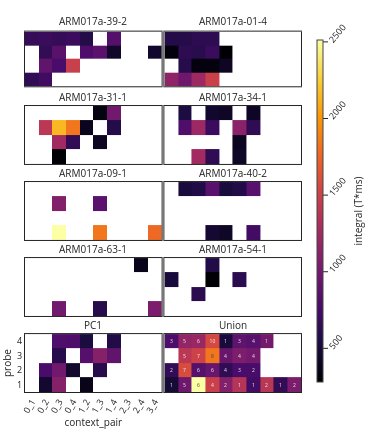

In [285]:
base_panelname = 'simple_tile_eg'
orientation = 'h'  # do not change

def plot_fingerprint(cellid):
    df = SC_DF.query(f"id == '{cellid}'")
    z = df.pivot(index='probe', columns='context_pair', values='value').values
    # z = z / np.max(z)
    z[z == 0] = np.nan
    heatmap = go.Figure(go.Heatmap(z=z, coloraxis='coloraxis', connectgaps=False))
    try:
        thismax = np.nanmax(z)
    except:
        thismax = 0

    return heatmap, thismax


n_egs = 8  # this  number must be even
cell_egs = eg_site_df.loc[:n_egs - 1, 'id'].tolist()
titles = cell_egs + ['PC1', 'Union']
max_vals = list()
fig = make_subplots(int(n_egs / 2 + 1), 2,
                    shared_xaxes=True, shared_yaxes=True,
                    horizontal_spacing=0.01, vertical_spacing=0.05,
                    subplot_titles=titles,
                    )

# individual neuron examples
for cc, cell_eg in enumerate(cell_egs):
    hmap, maxval = plot_fingerprint(cell_eg)
    max_vals.append(maxval)
    row, col = int(np.floor(cc / 2)) + 1, (cc % 2) + 1
    hmap = hmap['data']
    fig.add_traces(hmap, rows=[row] * len(hmap), cols=[col] * len(hmap))

# first principal component
PCA_arr = PCA_DF.query(f"site == '{site_eg}' and PC == 1"
                       ).pivot(index='probe', columns='context_pair', values='value').values
max_vals.append(PCA_arr.max())
PCA_arr[PCA_arr == 0] = np.nan
pc1 = go.Heatmap(z=PCA_arr, coloraxis='coloraxis', connectgaps=False)
# pc = px.imshow(PCA_arr, origin='lower',)['data']
fig.add_trace(pc1, row=int(n_egs / 2 + 1), col=1)

# union
union_df = DF.query(
    f"analysis == 'SC' and mult_comp_corr == 'bf_ncp' and site == '{site_eg}' and "
    f"metric == 'integral' "
    f"and value > 0"
).pivot_table(
    index='probe', columns='context_pair', values='value',
    aggfunc=('count', 'max'), observed=True
)

union = go.Figure(data=go.Heatmap(z=union_df['max'].values, coloraxis='coloraxis', connectgaps=False))
union.update_traces(text=union_df['count'],
                    texttemplate='%{text}')  # add the count number to each cell, this wont be displayed by jupyternotebooks...
union = union['data']
fig.add_traces(union, rows=[int(n_egs / 2 + 1)] * len(union), cols=[2] * len(union))



##### formating #######
# reduces size of subplot titles
fig.update_annotations(font_size=10)

# ensures spines, and no ticks or tick labels
fig.update_xaxes(scaleanchor='y',
                 constrain='domain',
                 showticklabels=False,
                 ticks='',
                 showline=True,
                 mirror=True,
                 )

fig.update_yaxes(constrain='domain',
                 showticklabels=False,
                 ticks='',
                 showline=True,
                 mirror=True,
                 )

# add labels only for the PCA only. cleaner
# context pairs
ctx_prs = [f"{int(pp.split('_')[0])}_{int(pp.split('_')[1])}"
                 for pp in union_df['count'].columns.to_list()]
fig.update_xaxes(title=dict(text='context_pair',
                            standoff=0,
                            font_size=10),showticklabels=True,
                 tickmode='array',
                 tickvals=list(range(len(ctx_prs))),
                 ticktext=ctx_prs,
                                     tickangle=-60,
                    tickfont_size=9,
                 col=1, row=5)
# probes
prbs = union_df.index.tolist()
fig.update_yaxes(title=dict(text='probe',
                            standoff=0,
                            font_size=10),showticklabels=True,
                 tickmode='array',
                 tickvals=list(range(len(prbs))),
                 ticktext=prbs,
                 tickfont_size=9,
                 col=1, row=5)

#
w, h = 4 * 96, 4.5 * 96
fig.update_layout(template="simple_white",
                  width=w, height=h,
                  margin=dict(l=10, r=10, t=30, b=10),
                  coloraxis=dict(showscale=True,
                                 colorscale='inferno',
                                 colorbar=dict(
                                     orientation='v',
                                     thicknessmode='fraction',
                                     thickness=0.02,
                                     lenmode='fraction',
                                     len=1,
                                     title=dict(text='integral (T*ms)',
                                                side='right',
                                                font_size=10),
                                     tickangle=-50,
                                     tickfont_size=9,
                                 ),
                                 ),
                  )

filename = figfolder / 'fig3_eg_coverages'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=w, height=h)
Image(img_bytes)

# Summary of coverages
considering ither single cells, best, union or first  PC

In [9]:
# Creates summary DF for these different quantifications of coverage

def union_cover(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    union = np.any(arr, axis=0)
    return union.sum()/union.size * 100

def best_neuron(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    neu_cvr = arr.sum(axis=1) / arr.shape[1] * 100
    return neu_cvr.max()

# all single neuron coverages
by_neuron = DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site', 'id']).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))

# best neuron in site
by_best =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site']).apply(best_neuron)
by_best.name = 'value'

# Union of single neurons, note the more strict bonferroni
by_union =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_ncp' and metric == 'integral'"
).groupby(['region', 'site']).apply(union_cover)
by_union.name = 'value'

# First PC coverage
by_PC1 = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site']).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))


to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1,}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)


# concatenate
to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)

In [10]:
# nubere or instances and sites to plot
toplot.query("quant in ['SC', 'PC1']").groupby(['region', 'quant']).agg(count=('value', 'count'))


count
region quant       
A1     PC1       36
       SC      1006
PEG    PC1       28
       SC       718

best_SC=33.54 PC1=41.45 union=53.44
SC=11.189992864973531


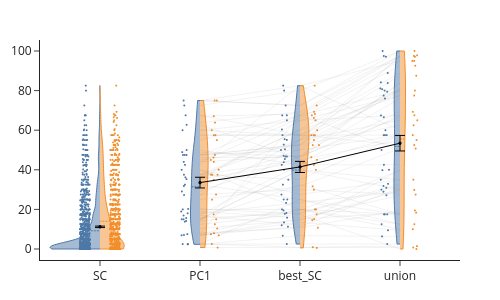

In [11]:
panelname = "coverage_summary"

fig = go.Figure()

# violins plust pointplots
for qq, quant in enumerate(['SC', 'PC1', 'best_SC', 'union']):
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            legendgroup='A1', scalegroup=f'', name='A1',
                            side='negative',
                            pointpos=-0.3,  # where to position points
                            line=dict(color=A1_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            legendgroup='PEG', scalegroup=f'', name='PEG',
                            side='positive',
                            pointpos=0.3,
                            line=dict(color=PEG_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )

# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  marker_size=2,
                  points='all',
                  jitter=0.1,
                  scalemode='width',
                  spanmode='hard')

# add lines connecting dots for groups
linearr = toplot.query("quant in ['best_SC', 'PC1', 'union']").pivot(index='site', columns='quant', values='value'
                                                                     ).loc[:, ['PC1', 'best_SC', 'union']].values

# individual grayed out lines
x = ['PC1', 'best_SC', 'union']
for ll, line in enumerate(linearr):
    fig.add_trace(go.Scatter(x=x, y=line,
                             mode='lines',
                             opacity=0.1,
                             line=dict(
                                 color='gray',
                                 width=1)
                             ,
                             showlegend=False)
                  )

# mean values pluse error bars
mean = linearr.mean(axis=0)
print(f'best_SC={mean[0]:.2f} PC1={mean[1]:.2f} union={mean[2]:.2f}')
err = sem(linearr, axis=0)
fig.add_trace(go.Scatter(x=x, y=mean,
                         mode='markers+lines',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=err,
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         line=dict(color='black',
                                   width=1
                                   )
                         ))

# mean for the single cell pooled values
SC_arr = toplot.query("quant == 'SC'").value.values
mean = SC_arr.mean()
print(f'SC={mean}')
err = sem(SC_arr)

fig.add_trace(go.Scatter(x=['SC'], y=[mean],
                         mode='markers',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=[err],
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         ))

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']

# test show
fig.update_layout(
    template='simple_white',
    margin=dict(l=40, r=40, t=40, b=40),
    xaxis=dict(range=[-0.6, 3.6]),
    violingap=0, violingroupgap=0, violinmode='overlay'
)
# fig.show()
img_bytes = fig.to_image(format="png", width=500, height=300)
Image(img_bytes)

## stat quantification
Only relevant to quantify between adyacent columns??

In [12]:
# compare between quantifications
stats_df = list()
for q0, q1 in itt.combinations(toplot.quant.unique(), 2):
    if 'SC' in [q0, q1]:
        x = toplot.query(f"quant == '{q0}'").value.values
        y = toplot.query(f"quant == '{q1}'").value.values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = mannwhitneyu(x,y)
        stat = 'mannwhitneyu'
    else:
        ddd = toplot.query(f"quant in {[q0, q1]}").pivot(index='site', columns='quant', values='value')
        x = ddd[q0].values
        y = ddd[q1].values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = wilcoxon(x,y)
        stat = 'wilcoxon'

    d = {'pair':f'{q0}_vs_{q1}', 'stat': stat, 'pvalue': out.pvalue}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,pair,stat,pvalue,signif
0,SC_vs_best_SC,mannwhitneyu,3.863550e-25,True
1,SC_vs_union,mannwhitneyu,1.553574e-26,True
2,SC_vs_PC1,mannwhitneyu,3.175605e-19,True
3,best_SC_vs_union,wilcoxon,1.094478e-06,True
4,best_SC_vs_PC1,wilcoxon,1.445772e-05,True
5,union_vs_PC1,wilcoxon,4.203865e-09,True


In [13]:
# compare regions per quantification
stats_df = list()
for quant in toplot.quant.unique():
    if quant == 'SC':
        idx = 'id'
    else:
        idx = 'site'

    x = toplot.query(f"quant == '{quant}' and region == 'A1'").value.values
    y = toplot.query(f"quant == '{quant}' and region == 'PEG'").value.values

    assert np.all(~np.isnan(x))
    assert np.all(~np.isnan(y))
    out = mannwhitneyu(x,y)
    stat = 'mannwhitneyu'

    d = {'quant':quant, 'stat': stat, 'pvalue': out.pvalue,
         'A1mean':np.mean(x), 'PEGmean':np.mean(y)}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,quant,stat,pvalue,A1mean,PEGmean,signif
0,SC,mannwhitneyu,7.754141e-08,9.179019,14.007597,True
1,best_SC,mannwhitneyu,2.386321e-01,39.841049,43.516234,False
2,union,mannwhitneyu,3.202441e-01,51.807753,55.527597,False
3,PC1,mannwhitneyu,2.181598e-01,31.438677,36.233766,False


# Region differences
same as summary for figure 2, but using first PC instead of individual neurons

integral, transition
diff_silence vs diff_diff MannwhitneyU 2.2272571656645547e-06
diff_silence vs diff_same MannwhitneyU 1.1018338254332506e-09
diff_silence vs same_silence MannwhitneyU 0.0034354709134796235
diff_diff vs diff_same MannwhitneyU 0.002411428003368543
diff_diff vs same_silence MannwhitneyU 0.25712308630521113
diff_same vs same_silence MannwhitneyU 0.2242053194731553
integral, region
A1 vs PEG MannwhitneyU 4.793036866886423e-10
last_bin, transition
diff_silence vs diff_diff MannwhitneyU 0.00015823321063355034
diff_silence vs diff_same MannwhitneyU 0.000371306045978586
diff_silence vs same_silence MannwhitneyU 0.1936207573319691
diff_diff vs diff_same MannwhitneyU 0.24193761705177608
diff_diff vs same_silence MannwhitneyU 0.20936946795448602
diff_same vs same_silence MannwhitneyU 0.13087211304733004
last_bin, region
A1 vs PEG MannwhitneyU 0.0063326356211330734


/auto/users/mateo/code/context_probe_analysis/src/utils/dataframes.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



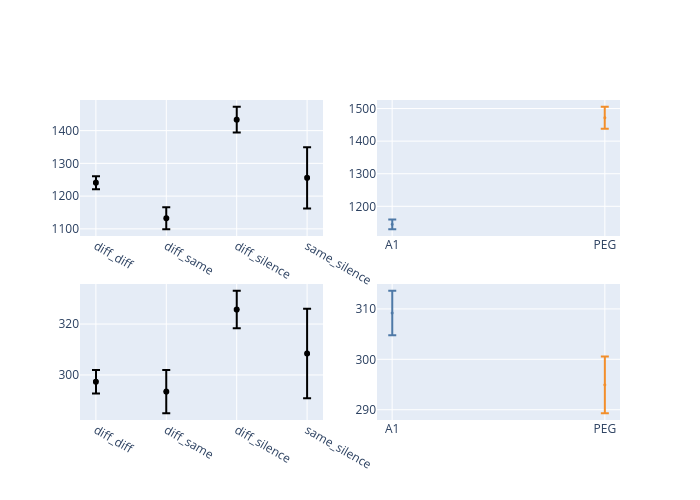

In [14]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(metric, category, innerDF):
    print(f'{metric}, {category}')
    tocalc = innerDF.query(f"metric == '{metric}' and value > 0")
    # tocalc = tocalc.groupby(['trans_pair', 'region', 'id']).agg(value=('value', 'mean')).reset_index()
    tocalc = tocalc.replace({'silence_diff': 'sile_diff', 'silence_same': 'sile_same'})

    if category == 'transition':
        ### transitions ###
        toplot = tocalc.groupby('trans_pair').agg(stat=('value', np.mean),
                                                  err=('value', sem))

        for c0,c1 in itt.combinations(tocalc.trans_pair.unique().tolist(), 2):
            x = tocalc.loc[tocalc.trans_pair == c0, 'value'].values.astype(float)
            y = tocalc.loc[tocalc.trans_pair == c1, 'value'].values.astype(float)
            stat, pval = mannwhitneyu(x,y)
            print(f'{c0} vs {c1} MannwhitneyU {pval}')

        return [
            go.Scatter(x=toplot.index, y=toplot['stat'], mode='markers',
                       marker=dict(color='black'),
                       error_y=dict(array=toplot['err'],
                                    color=name_to_hex('black')),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        x = tocalc.loc[tocalc.region == 'A1', 'value'].values.astype(float)
        y = tocalc.loc[tocalc.region == 'PEG', 'value'].values.astype(float)
        stat, pval = mannwhitneyu(x,y)

        toplot = tocalc.groupby('region').agg(stat=('value', np.mean),
                                              err=('value', sem))
        print(f'A1 vs PEG MannwhitneyU {pval}')

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        # for ii, color in enumerate([Blue, Orange]):
        #     reg_quant.append(go.Scatter(x=(toplot.index[ii],), y=(toplot['stat'][ii],), mode='markers',
        #                                 marker_color=color,
        #                                 error_y=dict(array=toplot['err'],
        #                                              color=color),
        #                                 showlegend=False),
        #                      )

        for rr, row in toplot.iterrows():
            reg_quant.append(go.Scatter(x=(row.name,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[row.name],
                                                    size=3),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[row.name],
                                                     # thickness=1,
                                                     # width=5,
                                                     ),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')




PCA_filtered = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp' "
    "and metric in ['integral', 'last_bin'] "
    "and value > 0 and value < 10000")
PCA_filtered = add_classified_contexts(PCA_filtered)


fig = make_subplots(2,2)
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):

        panelname = f'{met}_{cat}'

        if panelname in panels:
            panels.pop(panelname)

        panels[panelname].extend(plot_metric_quant_bars(met, cat, PCA_filtered))


        pan = panels[panelname]
        fig.add_traces(pan, cols=[cc+1]*len(pan), rows=[mm+1]*len(pan))
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [15]:
# count number of instances that are being compare
inst_by_reg = PCA_filtered.query("metric == 'integral'").groupby('region').agg(inst_count=('metric', 'count'), site_count=('id', pd.Series.nunique))
print(inst_by_reg)


inst_by_trans = PCA_filtered.query("metric == 'integral'").groupby('trans_pair').agg(inst_count=('metric', 'count'), site_count=('id', pd.Series.nunique))
print('\n', inst_by_trans)
print('\n',inst_by_reg.sum())

        inst_count  site_count
region                        
A1            2957          36
PEG           1804          28

               inst_count  site_count
trans_pair                          
diff_diff           2657          60
diff_same            802          57
diff_silence        1119          62
same_silence         183          56

 inst_count    4761
site_count      64
dtype: int64


In [16]:
PCA_filtered

,id,context_pair,probe,value,metric,mult_comp_corr,analysis,site,region,source,cluster_threshold,stim_count,PC,trans_pair
5228,ARM019a-PC-1,00_03,1,963.761678,integral,bf_cp,PCA,ARM019a,PEG,real,0.05,4,1.0,diff_silence
5298,ARM019a-PC-1,02_03,1,777.190641,integral,bf_cp,PCA,ARM019a,PEG,real,0.05,4,1.0,diff_diff
5326,ARM019a-PC-1,03_04,1,474.593413,integral,bf_cp,PCA,ARM019a,PEG,real,0.05,4,1.0,diff_diff
5368,ARM019a-PC-1,00_03,2,689.921543,integral,bf_cp,PCA,ARM019a,PEG,real,0.05,4,1.0,diff_silence
5410,ARM019a-PC-1,01_03,2,835.931277,integral,bf_cp,PCA,ARM019a,PEG,real,0.05,4,1.0,diff_diff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959679,TNC047a-PC-1,02_05,10,100.0,last_bin,bf_cp,PCA,TNC047a,PEG,real,0.05,10,1.0,diff_diff
3959945,TNC047a-PC-1,04_06,10,750.0,last_bin,bf_cp,PCA,TNC047a,PEG,real,0.05,10,1.0,diff_diff
3960078,TNC047a-PC-1,05_08,10,800.0,last_bin,bf_cp,PCA,TNC047a,PEG,real,0.05,10,1.0,diff_diff
3960154,TNC047a-PC-1,06_08,10,800.0,last_bin,bf_cp,PCA,TNC047a,PEG,real,0.05,10,1.0,diff_diff


# single cell coverage
including null dristribution

In [17]:
summary_real_vs_shuff_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220602_SC_real_shuffled'
SC_count = jl.load(summary_real_vs_shuff_DF_file)

                  mean       SEM        STD  count
source                                            
real         11.189993  0.373846  15.522485   1724
shuffled_eg   0.044215  0.007497   0.311295   1724


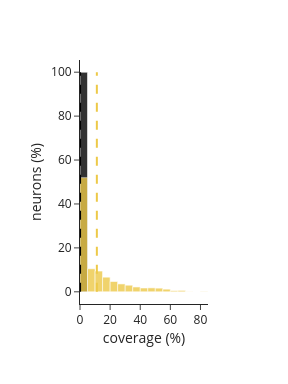

In [18]:
panelname = 'SC_coverage_not_random'

toplot = SC_count.query("metric ==  'integral' and  mult_comp_corr == 'bf_cp'").groupby(['source','id']).agg(
    space_cover_pct=("value", lambda x: sum(x>0)/len(x)*100)).reset_index()

fig = px.histogram(data_frame=toplot, x="space_cover_pct", nbins=25,
                   color='source',
                   category_orders={'source':['shuffled_eg','real']},
                   color_discrete_map={'real':Yellow, 'shuffled_eg':'black'},
                   histnorm='percent',
                   opacity=0.8,
                   barmode='overlay',
                   log_x=False)

# add mean vertical lines
means = toplot.groupby('source').agg(mean=('space_cover_pct', np.mean),
                                     SEM=('space_cover_pct', sem),
                                     STD=('space_cover_pct', np.std),
                                     count=('space_cover_pct', 'count'))
print(means)
for src, cc in zip(['shuffled_eg','real'],['black', Yellow]):
    xx = means.loc[src,'mean']
    fig.add_trace(go.Scatter(x=[xx, xx], y=[0,100], mode='lines',
                             line=dict(dash='dash', color=cc),
                             showlegend=False)
                  )


fig.update_xaxes(title=dict(text='coverage (%)', standoff=0))
fig.update_yaxes(title=dict(text='neurons (%)', standoff=0))
fig.update_layout(template='simple_white', showlegend=False)

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']
# fig.show()
img_bytes = fig.to_image(format="png", width=int(96*3), height=(96*4))
# img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)

# surface plot
What percentage of neurons are recruited as the stimulus space increases

In [19]:
# cont number of neurons and sites used for the subsampling experiment
neurons_site_count = SC_count.query("mult_comp_corr == 'bf_cp' and source == 'real' and "
                         "metric == 'integral'").groupby('stim_count').agg(cells=('id',pd.Series.nunique),
                                                                           sites=('site',pd.Series.nunique))
print(neurons_site_count)
print('9 and 10 stim used for subsampling')
print('total')
print(neurons_site_count.sum())
del(SC_count)

            cells  sites
stim_count              
4             871     35
9              10      1
10            843     28
9 and 10 stim used for subsampling
total
cells    1724
sites      64
dtype: int64


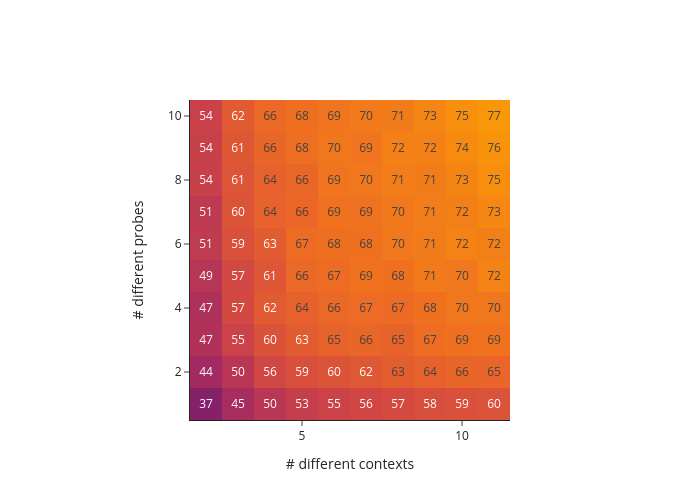

In [20]:
panelname = 'space_subsampling_nomarg'
subsampling_path = pl.Path(config['paths']['analysis_cache']) / '220310_pval_subsamp_DF_update'
subDF = jl.load(subsampling_path)

# defines the rage of the color map and the marginal plots. and what proportion of the plots the marginals should occupy
##### heat map of mean real values for all combinationse of context and probes #####
real = subDF.groupby(['source', 'n_ctx', 'n_prb']).agg(mean=('recruited_neu_pct', np.mean)
                                                       ).loc['real'].reset_index().pivot(index='n_prb', columns='n_ctx',
                                                                                         values='mean')

# heatmap
fig = go.Figure().add_trace(
    go.Heatmap(x=real.columns.values, y=real.index.values, z=real.values,
                coloraxis='coloraxis3')
)

fig.update_traces(text=real.values, texttemplate='%{text:.0f}')

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']

del(real, subDF) # gotta clean that ram

##### general
fig.update_layout(template='simple_white',autosize=False,
                  xaxis=dict(title_text='# different contexts',
                     anchor='y', constrain='domain', scaleanchor='y',
                             ),
                  yaxis=dict(title_text='# different probes',
                     anchor='x', autorange=True, constrain='domain',
                             ),
                  coloraxis3=dict(cmin=0, cmax=100,
                                 showscale=False,
                                 colorscale='inferno',
                                 colorbar=dict(
                                     title=dict(
                                         text=f'recruited_neu_pct (%)',
                                         side='right'
                                     ))))
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# figure layout

In [21]:
# simple plot layout and other figurewide configurations
def define_subplots():
    fig = make_subplots(rows=5, cols=4, vertical_spacing=0.01, horizontal_spacing=0.01,
                        column_widths=[1 / 4, 1 / 4, 1 / 4, 1 / 4],
                        row_heights=[1 / 8, 1 / 8, 3 / 8, 3 / 16, 3 / 16],
                        specs=[[{}, {}, {}, {}],
                               [{}, {}, {}, {}],
                               [{'colspan': 2}, None, {}, {}],
                               [{'colspan': 2, 'rowspan': 2}, None, {'l': 0.1, 't': 0.05}, {'t': 0.05}],
                               [None, None, {'l': 0.1}, {}]])
    # figure size in inches at different PPIs

    # ppi = 300  # high quality print standard (do i need this if I do postprocecing in vectors)
    ppi = 96  # www standard

    heigh = 6
    width = 6  # in inches

    # general fontsize adjustments for axess
    fig.update_xaxes(title=dict(standoff=0,
                                font_size=10,
                                ),
                     tickfont_size=9,
                     )
    fig.update_yaxes(title=dict(standoff=0,
                                font_size=10,
                                ),
                     tickfont_size=9,
                     )

    # specific tweaks
    _ = fig.update_layout(
        showlegend=False,
        template='simple_white',
        margin=dict(l=30, r=30, t=30, b=30),
        width=round(ppi * width), height=round(ppi * heigh),

        # PC and Union summary
        xaxis9=dict(domain=[0, 0.45],
                    range=xrange,
                    constrain='domain',
                    title_text=xtitle,
                    tickmode='array',
                    tickvals=xtickvals,
                    ticktext=xticktext,
                    tickangle=-60,
                    tickfont_size=9,
                    showline=False,
                    ),
        yaxis9=dict(scaleanchor='x9',
                    range=yrange,
                    domain=[0.5,0.75],
                    constrain='domain',
                    title_text=ytitle,
                    tickmode='array',
                    tickvals=ytickvals,
                    ticktext=yticktext,
                    tickfont_size=9,
                    showline=False,
                    ),

        # Colorbars asociated with single neurons examples and PC1/Union.
        coloraxis=dict(showscale=True,
                       colorscale='Greens',
                       colorbar=dict(
                           orientation='h',
                           thicknessmode='fraction',
                           thickness=0.01,
                           lenmode='fraction',
                           len=0.22,
                           title=dict(text='integral (T*ms)',
                                      side='bottom',
                                      font_size=10),
                           tickangle=-50,
                           tickfont_size=9,
                           xanchor='left', x=0,
                           yanchor='top', y=0.45)
                       ),
        coloraxis2=dict(showscale=True,
                        colorscale='Purples',
                        colorbar=dict(
                            orientation='h',
                            thicknessmode='fraction',
                            thickness=0.01,
                            lenmode='fraction',
                            len=0.22,
                            title=dict(text='last bin (ms)',
                                       side='bottom',
                                       font_size=10),
                            tickangle=-50,
                            tickfont_size=9,
                            xanchor='left', x=0.22,
                            yanchor='top', y=0.45)
                        ),

        # single cell histogram
        bargap=0, bargroupgap=0, barmode='overlay',
        xaxis10=dict(domain=[0.53, 0.70],
                     autorange=True,
                     constrain='domain',
                     title=dict(text='coverage %',
                                standoff=0)
                     ),
        yaxis10=dict(range=[0,100],
                     scaleanchor='x10',
                     scaleratio=1.5,
                     constrain='domain',
                     title_text='neurons %'),

        # subsampling heatmap
        xaxis11=dict(domain=[0.75, 1],
                     title_text='# different contexts',
                     constrain='domain',
                     tickmode='array',
                     tickvals=[2, 5, 8, 11],
                     ticktext=[2, 5, 8, 11],
                     ),
        yaxis11=dict(title_text='# different probes',
                     scaleanchor='x11',
                     autorange=True,
                     constrain='domain',
                     tickmode='array',
                     tickvals=[1, 4, 7, 10],
                     ticktext=[1, 4, 7, 10],
                     ),
        coloraxis3=dict(showscale=False,
                        cmin=0, cmax=100,
                        colorscale='inferno',
                        ),

        # violin plots parameters
        xaxis12=dict(domain=[0, 0.65],
                     range=[-0.6, 3.6],
                     title_text=' '),
        yaxis12=dict(domain=[0,0.3],
                     range=[0, 100],
                     title_text='coverage %'),
        violingap=0, violingroupgap=0, violinmode='overlay',

        # category differences quantification
        xaxis13=dict(domain=[0.75, 0.91], matches='x15', showticklabels=False),
        yaxis13=dict(title=dict(text='integral (T*ms)', font_color=AMPCOLOR)),

        xaxis14=dict(domain=[0.92, 1], matches='x16', showticklabels=False),
        yaxis14=dict(matches='y13', showticklabels=False),

        xaxis15=dict(domain=[0.75, 0.91], title=dict(text='context type pair'), tickangle=-45, ),
        yaxis15=dict(title=dict(text='last bin (ms)', font_color=DURCOLOR)),

        xaxis16=dict(domain=[0.92, 1], title=dict(text='region', standoff=39)),
        yaxis16=dict(matches='y15', showticklabels=False),
    )

    # format heatmap examples
    for cc in range(len(cell_egs)):
        row, col = int(np.floor(cc / 4)) + 1, (cc % 4) + 1
        # print(row, col)
        scale_anchor = 'y' if cc == 0 else f'y{cc + 1}'

        # ensure 1:1 x:y ratio
        fig.update_xaxes(scaleanchor=scale_anchor,
                         constrain='domain',
                         range=xrange,
                         showticklabels=False,
                         ticks='',
                         showline=False,
                         row=row, col=col)
        fig.update_yaxes(constrain='domain',
                         range=yrange,
                         showticklabels=False,
                         ticks='',
                         showline=False,
                         row=row, col=col)

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 0, 0.74),
        ('c', 0.48, 0.74),
        ('d', 0.7, 0.74),
        ('e', 0, 0.35),
        ('f', 0.7, 0.35),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)

    return fig, round(ppi * width), round(ppi * heigh)


f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]  [ (1,4) x4,y4   ]
[ (2,1) x5,y5   ]  [ (2,2) x6,y6   ]  [ (2,3) x7,y7   ]  [ (2,4) x8,y8   ]
[ (3,1) x9,y9             -        ]  [ (3,3) x10,y10 ]  [ (3,4) x11,y11 ]
⎡ (4,1) x12,y12           -        ⎤  [ (4,3) x13,y13 ]  [ (4,4) x14,y14 ]
⎣      :                  :        ⎦  [ (5,3) x15,y15 ]  [ (5,4) x16,y16 ]



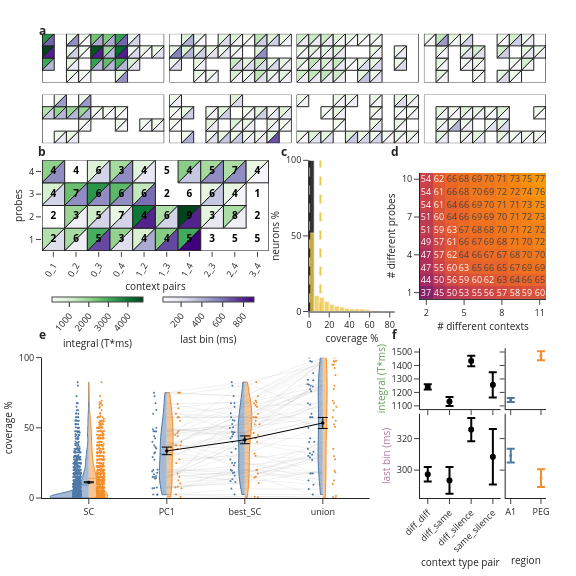

In [22]:
##### test  plot
fig, pw, ph = define_subplots()

# example tilings
for  cc, cell_eg in enumerate(cell_egs):
    panelname = f'tile_eg_{cc}'
    row, col = int(np.floor(cc/4))+1, (cc%4)+1
    # print(row, col)
    pan = panels[panelname]
    fig.add_traces(pan, rows=[row]*len(pan), cols=[col]*len(pan))

# PC1 and union tiling
pan = panels[f'tile_eg_PC']
fig.add_traces(pan, rows=[3]*len(pan), cols=[1]*len(pan))

# real vs shuffled histograms
pan = panels['SC_coverage_not_random']
fig.add_traces(pan, rows=[3]*len(pan), cols=[3]*len(pan))

# heatmap soundspace subsampling
pan = panels['space_subsampling_nomarg']
fig.add_traces(pan, rows=[3]*len(pan), cols=[4]*len(pan))

# violin plots cover sumary
pan = panels['coverage_summary']
fig.add_traces(pan, rows=[4]*len(pan), cols=[1]*len(pan))

# parameter comparison like in figure 2
pan = panels['integral_transition']
fig.add_traces(pan, rows=[4]*len(pan), cols=[3]*len(pan))

pan = panels['integral_region']
fig.add_traces(pan, rows=[4]*len(pan), cols=[4]*len(pan))


pan = panels['last_bin_transition']
fig.add_traces(pan, rows=[5]*len(pan), cols=[3]*len(pan))

pan = panels['last_bin_region']
fig.add_traces(pan, rows=[5]*len(pan), cols=[4]*len(pan))

# fig.show()
img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)

# saves PNG and SVG

In [23]:
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'figure_03'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))